In [21]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from random import randint, normalvariate
import matplotlib.pyplot as plt
from numpy import argmax

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Импорт датасета и предобученной модели

In [22]:
train_trans = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.262))
])
test_trans = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.262))
])

dataset = datasets.CIFAR10(root='./data', download=True,
                         transform=train_trans)
test_data = datasets.CIFAR10(root='./data', download=True,
                           train=False, transform=test_trans)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
ind_2_name = {0 : 'airplane',
1 : 'automobile',
2 : 'bird',
3 : 'cat',
4 : 'deer',
5 : 'dog',
6 : 'frog',
7 : 'horse',
8 : 'ship',
9 : 'truck'}

In [24]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, num_workers=4)

In [25]:
net = torchvision.models.squeezenet1_0(pretrained=True)

In [26]:
new_features = nn.Sequential(*[nn.Conv2d(3, 96, kernel_size=3), nn.ReLU()]+list(net.features.children())[3:-2])
net.features = new_features

net.classifier = nn.Sequential(
    nn.Conv2d(512, 10, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1,1)))

net.num_classes = 10

In [27]:
ex =  torch.randn(2, 3, 32, 32)
net.features(ex).shape

torch.Size([2, 512, 15, 15])

In [28]:
ex =  torch.randn(2, 3, 32, 32)
net(ex).shape

torch.Size([2, 10])

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
net = net.to(device)

In [30]:
for i, p in enumerate(net.features.parameters()):
    if i == 0:
        print(p.shape)
        p.requires_grad = True
    p.requires_grad = True

torch.Size([96, 3, 3, 3])


### Учим модель

In [31]:
for epoch in range(10):
    reporter = tqdm(enumerate(train_loader, 0), total=len(train_loader))
    
    for i, data in reporter:
        inputs, targets = data[0].to(device), data[1].to(device)
        predictions = net(inputs)
        loss = criterion(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if i % 50 == 0:
            cur_loss = loss.item()
            reporter.set_description('loss %.2f'%cur_loss)

loss 0.37: 100%|█████████████████████████████████████████████████████████████████████| 782/782 [00:36<00:00, 21.43it/s]


### Проверяем качество модели

In [32]:
reporter2 = tqdm(enumerate(test_loader), total=len(test_loader))

total_examples = len(test_loader.dataset)
num_matches = 0

for i, data in reporter2:
    with torch.no_grad():
        inputs, targets = data[0].to(device), data[1].to(device)
        
        predictions = net(inputs)
        
        _, label_predictions = predictions.max(1)
        
        num_matches += label_predictions.eq(targets).sum().item()
        
print('\nTest accuracy: %.2f%%'%(100.*num_matches/total_examples))

100%|████████████████████████████████████████████████████████████████████████████████| 157/157 [00:03<00:00, 46.99it/s]


Test accuracy: 82.35%


### FGSM атакa

In [35]:
def fgsm_attack(init_input, label, model, eps=1e-3):
    # Проводит FGSM атаку на выбранную картинку и модель
    true_output = torch.tensor([label]).to(device)
    init_input = init_input.to(device)
    init_input.requires_grad = True
    
    init_output = model(init_input)
    # Вычисляем лосс и считаем градиент
    loss = F.cross_entropy(init_output, true_output)
    g = torch.autograd.grad(loss, init_input, allow_unused=True)
    
    # Делаем шаг FGSM - метода
    new_input = init_input + eps * torch.sign(g[0])
    
    # Получаем новую метку 
    new_output = model(new_input)
    new_output = F.softmax(new_output, dim=1)
    new_label = new_output.max(1)[1].item()
    confidence = new_output.max(1)[0].item()
    return new_input.cpu(), new_label, 100. * confidence

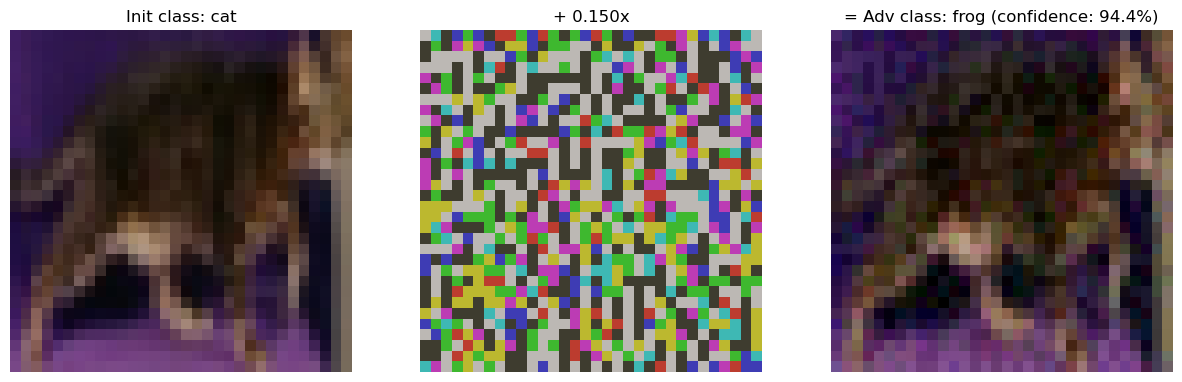

In [36]:
def get_img(batch_tensor):
# Переводит тензор обратно в картинку    
    inverse_transform = transforms.Normalize(
        (-0.491/0.247, -0.482/0.243, -0.447/0.262),
        (1/0.247, 1/0.243, 1/0.262)
    )
    if batch_tensor.shape[0] == 3:
        res = inverse_transform(batch_tensor.clone())
    else:
        res = inverse_transform(batch_tensor[0].clone())
    res = torch.clamp(res, 0, 1)
    return res.detach().cpu().squeeze().permute(1, 2, 0).numpy()

r_ind = randint(0, len(test_loader.dataset))

init_tensor = test_loader.dataset[r_ind][0].unsqueeze(0)
init_label = test_loader.dataset[r_ind][1]
init_class = ind_2_name[init_label]
init_img = get_img(init_tensor)

EPS = 0.15
adv_tensor, adv_label, conf = fgsm_attack(init_tensor, init_label, net, EPS)
adv_class = ind_2_name[adv_label]
adv_img = get_img(adv_tensor)

diff_img = get_img((adv_tensor - init_tensor) / EPS)

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Init class: ' + init_class)
plt.imshow(init_img)
plt.axis('off')

plt.subplot(132)
plt.title('+ %.3fx'%EPS)
plt.imshow(diff_img)
plt.axis('off')

plt.subplot(133)
plt.title('= Adv class: %s (confidence: %.1f%%)'%(adv_class, conf))
plt.imshow(adv_img)
plt.axis('off')

plt.show()

### OnePixel атака

In [39]:
def init_population(bounds, popsize):
    population = []
    for _ in range(0, popsize):
        rand_x = randint(bounds[0], bounds[1])
        rand_y = randint(bounds[0], bounds[1])
        
        rand_r = normalvariate(0, 1)
        rand_g = normalvariate(0, 1)
        rand_b = normalvariate(0, 1)
        
        population += [(rand_x, rand_y,
                        torch.tensor([rand_r, rand_g, rand_b])
                       )]
    return population

def score_population(population, init_input, label, model):
    population_scores = []
    true_output = torch.tensor([label]).to(device)
    init_input = init_input.to(device)
    
    for cell in population:
        cell_input = init_input.clone()
        cell_input[0, :, cell[0], cell[1]] = cell[2]
        
        cell_output = model(cell_input)
        cell_loss = F.cross_entropy(cell_output, true_output).item()
        
        population_scores += [cell_loss]
    
    return population_scores

def recombine_population(population, F=0.5):
    children_population = []
    for _ in range(0, len(population)):
        r_1 = randint(0, len(population)-1)
        r_2 = randint(0, len(population)-1)
        r_3 = randint(0, len(population)-1)
        
        new_x = int(population[r_1][0] + F * (population[r_2][0]- population[r_3][0]))
        new_x = max(0, min(new_x, 31))
        new_y = int(population[r_1][1] + F * (population[r_2][1]- population[r_3][1]))
        new_y = max(0, min(new_y, 31))
        
        new_rgb = population[r_1][2] + F * (population[r_2][2] - population[r_3][2])
        children_population += [(new_x, new_y, new_rgb)]
    return children_population

# Проводит OnePixel атаку на выбранную картинку и модель
def one_pixel_attack(best_cell, init_input, label, model):
    true_output = torch.tensor([label]).to(device)
    init_input = init_input.to(device)
    
    cell_input = init_input.clone()
    cell_input[0, :, best_cell[0], best_cell[1]] = best_cell[2]
    
    cell_output = model(cell_input)
    cell_output = F.softmax(cell_output, dim=1)
    new_label = cell_output.max(1)[1].item()
    confidence = cell_output.max(1)[0].item()
    
    return cell_input.cpu(), new_label, 100.*confidence

def evolve(population, init_input, label, model, n_steps=100, F=0.5):
    old_population = population
    old_scores = score_population(population, init_input, label, model)
    
    new_population = []
    new_scores = []
    for step in tqdm(range(n_steps)):
        new_population = recombine_population(old_population, F)
        new_scores = score_population(new_population, init_input, label, model)
        
        for i in range(len(new_population)):
            if new_scores[i] < old_scores[i]:
                new_population[i] = old_population[i]
        old_population = new_population
        old_scores = new_scores
    
    return old_population, old_scores

population = init_population((0, 31), 400)

In [40]:
%%time

population, scores = evolve(population, init_tensor, init_label, net, n_steps=50)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:12<00:00,  1.44s/it]

CPU times: total: 1min 9s
Wall time: 1min 13s


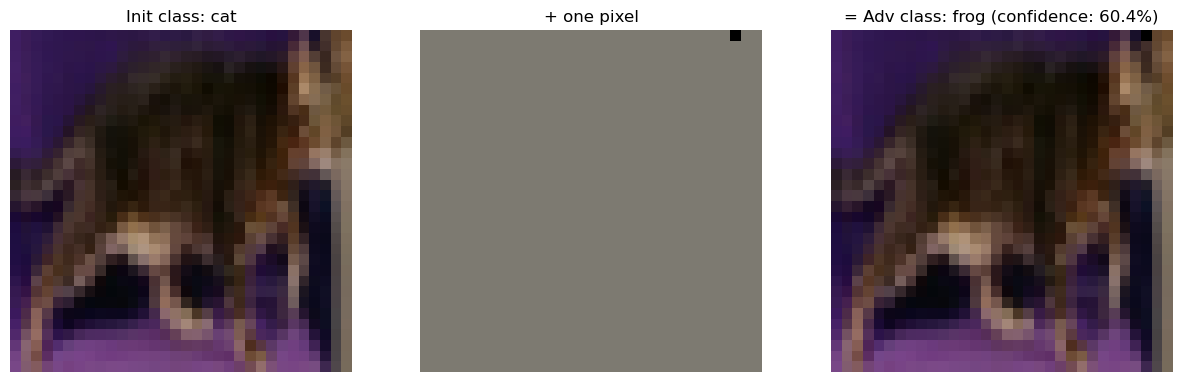

In [41]:
best_cell = population[argmax(scores)]

adv_tensor, adv_label, conf = one_pixel_attack(best_cell, init_tensor, init_label, net)
adv_class = ind_2_name[adv_label]
adv_img = get_img(adv_tensor)

diff_img = get_img((adv_tensor - init_tensor) / EPS)

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title('Init class: ' + init_class)
plt.imshow(init_img)
plt.axis('off')

plt.subplot(132)
plt.title('+ one pixel')
plt.imshow(diff_img)
plt.axis('off')

plt.subplot(133)
plt.title('= Adv class: %s (confidence: %.1f%%)'%(adv_class, conf))
plt.imshow(adv_img)
plt.axis('off')

plt.show()